## 📊 Cleaned Dataset: Hasil Pembersihan Data Mentah

Pada tahap ini, data mentah dari file `datasetTubes.csv` diproses untuk menghilangkan informasi yang tidak relevan dan memastikan format data konsisten. Proses meliputi:

- Penggabungan multi-baris header menjadi satu nama kolom yang jelas.
- Reshape data ke format panjang (*long format*) untuk memudahkan analisis lanjutan.
- Pemisahan kolom gabungan menjadi kolom `Tahun` dan `Kategori`.
- Penyaringan hanya nilai numerik yang valid, dengan mengabaikan deskripsi teks.
- Konversi nilai string ke format numerik (`float`).
- Penyimpanan data ke file `.csv` dengan nama otomatis berurutan.

Hasilnya adalah dataset yang bersih dan siap digunakan untuk tahap analisis berikutnya.

In [ ]:
import pandas as pd
import numpy as np
import os

# Load file CSV
df = pd.read_csv("dataset/datasetTubes.csv")

# Ambil header tahun dan kategori dari baris ke-1 dan ke-2
header_row_1 = df.iloc[1].ffill()
header_row_2 = df.iloc[2]

# Gabungkan menjadi nama kolom
multi_index = [
    f"{str(year).strip()} - {str(cat).strip()}"
    for year, cat in zip(header_row_1[1:], header_row_2[1:])
]

# Ambil data dari baris ke-4 ke bawah
data_rows = df.iloc[3:, :len(multi_index)+1]
data_rows.columns = ["Provinsi"] + multi_index
data_rows = data_rows[data_rows["Provinsi"].notna()]  # Hapus baris kosong

# Reshape ke long format
df_melted = data_rows.melt(id_vars="Provinsi", var_name="Tahun_Kategori", value_name="Nilai")

# Pisahkan menjadi dua kolom: Tahun dan Kategori
df_melted[['Tahun', 'Kategori']] = df_melted['Tahun_Kategori'].str.split(' - ', expand=True)

# Ganti strip "-" yang berarti kosong dengan "0"
df_melted['Nilai'] = df_melted['Nilai'].replace('-', '0')

# Hapus koma dan ubah ke float
df_melted['Nilai'] = df_melted['Nilai'].str.replace(',', '', regex=False).astype(float)

# Ubah nilai negatif menjadi positif
df_melted['Nilai'] = df_melted['Nilai'].abs()

# Hapus/Drop kolom gabungan
df_melted.drop(columns="Tahun_Kategori", inplace=True)

# Simpan hasilnya ke file baru (opsional)
# Tentukan nama dasar file dan folder tujuan
base_filename = "datasetTubes_cleaned_fixed"
folder = "hasil-preposesing-data"
i = 1

# Cari nomor urutan file berikutnya yang belum ada
while True:
    output_filename = f"{base_filename}_{i}.csv"
    output_path = os.path.join(folder, output_filename)
    if not os.path.exists(output_path):
        break
    i += 1

# Simpan file dengan nama yang otomatis berurutan
df_melted.to_csv(output_path, index=False)

# Tampilkan pesan konfirmasi
print(f"File berhasil disimpan: {output_path}")

# Tampilkan hasil awal
print(df_melted.head())

File berhasil disimpan: hasil-preposesing-data\datasetTubes_cleaned_fixed_1.csv
         Provinsi     Nilai      Tahun       Kategori
0            Aceh    3363.9  2013-2014  Kawasan Hutan
1  Sumatera Utara    4675.2  2013-2014  Kawasan Hutan
2  Sumatera Barat    3330.3  2013-2014  Kawasan Hutan
3            Riau  180786.5  2013-2014  Kawasan Hutan
4           Jambi   12809.6  2013-2014  Kawasan Hutan


## 📈 Preprocessing Data: Agregasi dan Visualisasi Tren Deforestasi

Pada tahap ini, data yang telah dibersihkan diolah lebih lanjut melalui teknik agregasi untuk menghasilkan informasi yang bermakna. Langkah-langkah yang dilakukan antara lain:

1. **Analisis Tren Deforestasi Nasional per Tahun**  
   Data difilter berdasarkan kategori “Deforestasi”, kemudian diakumulasi total per tahun dan divisualisasikan dalam bentuk *line chart*.

2. **Perbandingan Luas Kawasan Hutan dan APL**  
   Data kategori “Kawasan Hutan” dan “APL” diolah per tahun dan ditampilkan dalam bentuk *stacked bar chart* untuk memperlihatkan proporsi tiap kategori dari waktu ke waktu.

3. **Identifikasi Provinsi dengan Deforestasi Tertinggi**  
   Total deforestasi dihitung untuk setiap provinsi, kemudian ditampilkan 10 provinsi dengan angka deforestasi tertinggi dalam bentuk *pie chart*.

4. **Distribusi Deforestasi dalam Dimensi Spasial dan Temporal**  
   Data disusun dalam format *pivot table* untuk memvisualisasikan deforestasi per provinsi dan tahun menggunakan *heatmap*.

Teknik agregasi ini membantu dalam memahami pola, tren, dan distribusi deforestasi secara nasional maupun lokal.

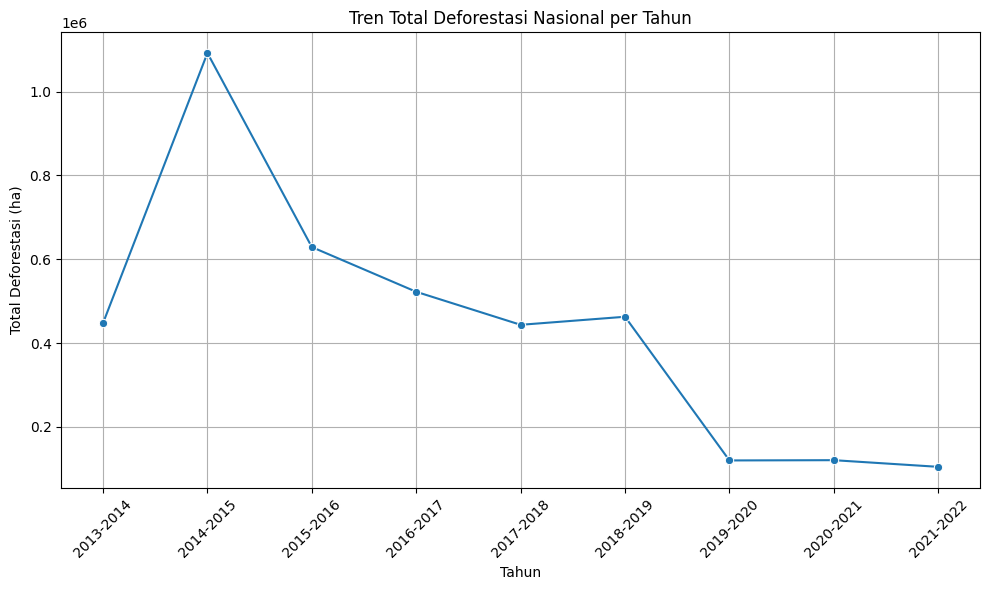

In [11]:
# 1. Tren Total Deforestasi Nasional per Tahun (Line Chart)
import matplotlib.pyplot as plt
import seaborn as sns

# Filter kategori deforestasi
df_deforestasi = df_melted[df_melted['Kategori'].str.contains("Deforestasi", case=False)]
# df_deforestasi = df_melted[df_melted['Kategori'].str.contains("Deforestasi", case=False)]

# Agregasi total per tahun
total_per_tahun = df_deforestasi.groupby("Tahun")["Nilai"].sum().reset_index()

# Visualisasi line chart
plt.figure(figsize=(10, 6))
sns.lineplot(data=total_per_tahun, x="Tahun", y="Nilai", marker="o")
plt.title("Tren Total Deforestasi Nasional per Tahun")
plt.ylabel("Total Deforestasi (ha)")
plt.xlabel("Tahun")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

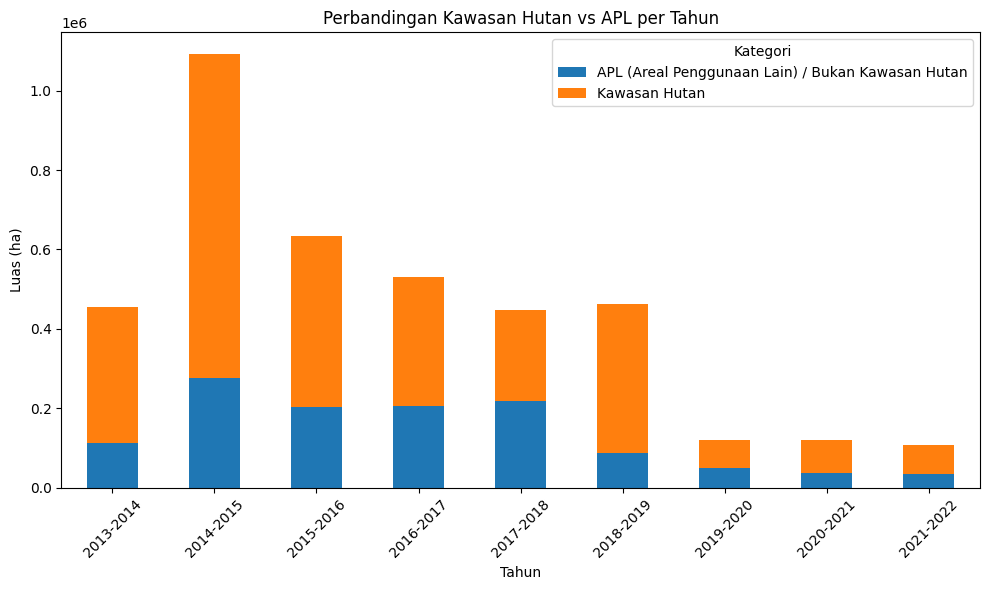

In [12]:
# 2. Perbandingan Kawasan Hutan vs APL per Tahun (Stacked Bar Chart)
# Filter data yang mengandung 'Kawasan Hutan' atau 'APL'
df_kawasan_apl = df_melted[df_melted['Kategori'].str.contains("Kawasan Hutan|APL", case=False)]

# Agregasi
kawasan_apl_tahun = df_kawasan_apl.groupby(['Tahun', 'Kategori'])['Nilai'].sum().unstack()

# Plot stacked bar chart
kawasan_apl_tahun.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Perbandingan Kawasan Hutan vs APL per Tahun")
plt.ylabel("Luas (ha)")
plt.xlabel("Tahun")
plt.xticks(rotation=45)
plt.legend(title="Kategori")
plt.tight_layout()
plt.show()

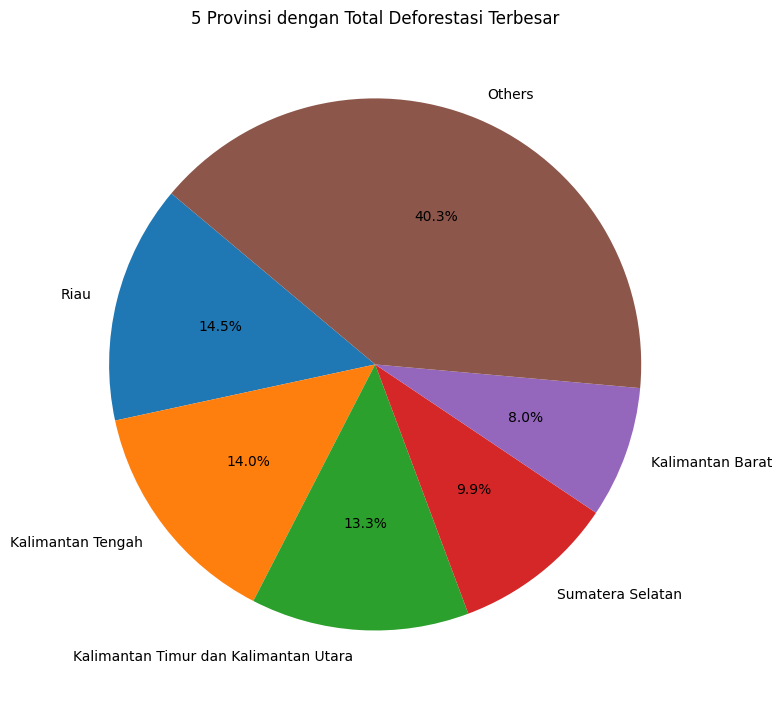

In [13]:
# 3. Perbandingan Kawasan Hutan vs APL per Tahun (Stacked Bar Chart)
# Agregasi total deforestasi per provinsi
top_deforestasi = df_deforestasi.groupby("Provinsi")["Nilai"].sum().sort_values(ascending=False)

# Ambil 5 provinsi teratas
top_5 = top_deforestasi.head(5)

# Hitung sisa provinsi sebagai "Others"
others = top_deforestasi.iloc[5:].sum()

# Gabungkan top 5 dan Others
top_5_with_others = top_5.copy()
top_5_with_others["Others"] = others

# Pie chart
plt.figure(figsize=(8, 8))
top_5_with_others.plot(kind="pie", autopct="%1.1f%%", startangle=140)
plt.ylabel("")
plt.title("5 Provinsi dengan Total Deforestasi Terbesar")
plt.tight_layout()
plt.show()

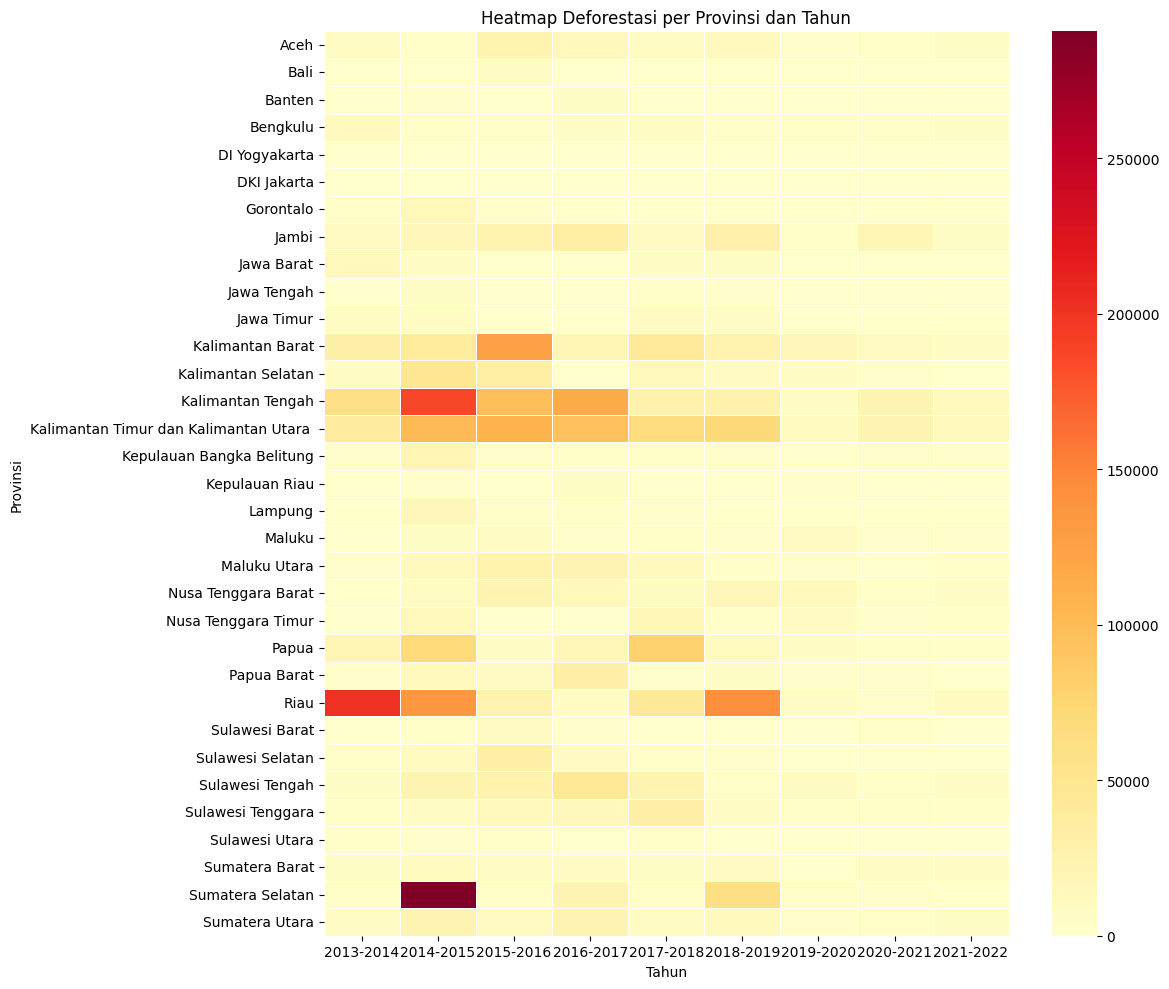

In [14]:
# 4. Heatmap Deforestasi per Provinsi dan Tahun
# Agregasi
heatmap_data = df_deforestasi.groupby(["Provinsi", "Tahun"])["Nilai"].sum().reset_index()
heatmap_pivot = heatmap_data.pivot(index="Provinsi", columns="Tahun", values="Nilai").fillna(0)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_pivot, cmap="YlOrRd", linewidths=0.5)
plt.title("Heatmap Deforestasi per Provinsi dan Tahun")
plt.xlabel("Tahun")
plt.ylabel("Provinsi")
plt.tight_layout()
plt.show()

In [15]:
# 5 Heatmap Mapping Deforestasi per Provinsi dan Tahun

import folium
import pandas as pd
import json
import os
import branca.colormap as cm

# Mapping nama provinsi di CSV ke nama di GeoJSON
provinsi_mapping = {
    "Aceh": "DI. ACEH",
    "Bali": "BALI",
    "Banten": "PROBANTEN",
    "Bengkulu": "BENGKULU",
    "DI Yogyakarta": "DAERAH ISTIMEWA YOGYAKARTA",
    "DKI Jakarta": "DKI JAKARTA",
    "Gorontalo": "GORONTALO",
    "Jambi": "JAMBI",
    "Jawa Barat": "JAWA BARAT",
    "Jawa Tengah": "JAWA TENGAH",
    "Jawa Timur": "JAWA TIMUR",
    "Kalimantan Barat": "KALIMANTAN BARAT",
    "Kalimantan Selatan": "KALIMANTAN SELATAN",
    "Kalimantan Tengah": "KALIMANTAN TENGAH",
    "Kalimantan Timur dan Kalimantan Utara ": "KALIMANTAN TIMUR",  # Disesuaikan
    "Kepulauan Bangka Belitung": "BANGKA BELITUNG",
    "Kepulauan Riau": None,  # Tidak ada di GeoJSON
    "Lampung": "LAMPUNG",
    "Maluku": "MALUKU",
    "Maluku Utara": "MALUKU UTARA",
    "Nusa Tenggara Barat": "NUSATENGGARA BARAT",
    "Nusa Tenggara Timur": "NUSA TENGGARA TIMUR",
    "Papua": "IRIAN JAYA TENGAH",
    "Papua Barat": "IRIAN JAYA BARAT",
    "Riau": "RIAU",
    "Sulawesi Barat": None,  # Tidak ada di GeoJSON
    "Sulawesi Selatan": "SULAWESI SELATAN",
    "Sulawesi Tengah": "SULAWESI TENGAH",
    "Sulawesi Tenggara": "SULAWESI TENGGARA",
    "Sulawesi Utara": "SULAWESI UTARA",
    "Sumatera Barat": "SUMATERA BARAT",
    "Sumatera Selatan": "SUMATERA SELATAN",
    "Sumatera Utara": "SUMATERA UTARA",
}

# Load CSV
data = pd.read_csv("hasil-preposesing-data/datasetTubes_cleaned_fixed_1.csv")

# Filter data
data = data[data["Kategori"] == "Kawasan Hutan"]
data = data[data["Tahun"] == "2014-2015"]

# Mapping nama provinsi
data["Provinsi_geojson"] = data["Provinsi"].map(provinsi_mapping)

# Drop baris dengan provinsi yang tidak bisa dipetakan
data = data.dropna(subset=["Provinsi_geojson"])

# Load GeoJSON
with open("indonesia_provinces.geojson", "r", encoding="utf-8") as f:
    geojson = json.load(f)

# Ambil semua tahun unik
unique_years = sorted(data["Tahun"].unique())

# Buat folder output
output_folder = "output-peta-deforestasi"
os.makedirs(output_folder, exist_ok=True)

# Loop untuk tiap tahun
for i, tahun in enumerate(unique_years, start=1):
    df_filtered = data[(data["Tahun"] == tahun)]

    # Ambil nilai min dan max
    min_nilai = df_filtered["Nilai"].min()
    max_nilai = df_filtered["Nilai"].max()

    # Peta dasar
    m = folium.Map(location=[-2.5, 118], zoom_start=5, tiles='cartodbpositron')

    # Choropleth
    # Tambah Choropleth layer (tanpa membalik nilai)
    choropleth = folium.Choropleth(
        geo_data=geojson,
        name="Choropleth Deforestasi",
        data=df_filtered,
        columns=["Provinsi_geojson", "Nilai"],
        key_on="feature.properties.Propinsi",
        fill_color="YlOrRd",  # Warna default: kuning → merah
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=f"Luas Deforestasi (ha) - {tahun}",
        highlight=True
    ).add_to(m)

    # Tooltip per provinsi
    folium.GeoJson(
        geojson,
        name="Provinsi",
        style_function=lambda feature: {
            "fillOpacity": 0,
            "weight": 0
        },
        tooltip=folium.GeoJsonTooltip(
            fields=["Propinsi"],
            aliases=["Provinsi:"],
            localize=True,
            sticky=False,
            labels=True,
            toLocaleString=True
        )
    ).add_to(m)

    # Tambahkan popup dengan nilai deforestasi
    for feature in geojson["features"]:
        provinsi_name = feature["properties"]["Propinsi"]
        match = df_filtered[df_filtered["Provinsi_geojson"] == provinsi_name]
        if not match.empty:
            nilai = match["Nilai"].values[0]
            folium.GeoJson(
                feature,
                style_function=lambda x: {"fillOpacity": 0, "color": "none"},
                popup=folium.Popup(f"{provinsi_name}: {nilai:,.2f} ha", max_width=300)
            ).add_to(m)

    # Simpan
    output_path = os.path.join(output_folder, f"deforestasi_{i}.html")
    m.save(output_path)
    print(f"Peta {tahun} berhasil disimpan ke: {output_path}")


Peta 2014-2015 berhasil disimpan ke: output-peta-deforestasi\deforestasi_1.html
